In [1]:
import igraph
import networkx as nx
import numpy as np
import pandas as pd
import copy
from matplotlib import cm
import math
import os
import subprocess

[2, 3, 3, 3, 3, 2, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 3, 2, 3, 3, 3, 3, 2]


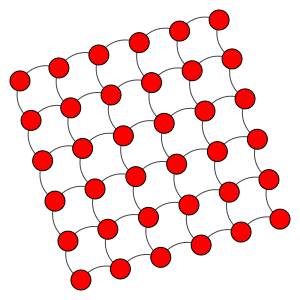

In [15]:
dims = [6, 6]
nei = 1
g = igraph.Graph.Lattice(dims, nei, directed=False, mutual=True, circular=False)
visual = {}
visual["bbox"] = (300, 300)
visual["margin"] = 20
visual["vertex_size"] = 20
print(g.degree())
igraph.plot(g, edge_curved=True, title='SS', **visual)

In [16]:
outdir = '/tmp'
mapw = 5
maph = 5
dim = [mapw, maph]
nei = 1
g = igraph.Graph.Lattice(dim, nei, directed=False, mutual=True, circular=False)
layout = g.layout('kk')
nepochs = 100

s0 = 500
i0 = 5
r0 = 10
N = totalparticles = s0 + i0 + r0
beta = 0.4
gamma = 0.5

SUSCEPTIBLE = 0
INFECTED = 1
RECOVERED = 2

totalvertices = mapw*maph
status = np.ndarray(totalparticles, dtype=int)
status[0: s0] = SUSCEPTIBLE
status[s0:s0+i0] = INFECTED
status[s0+i0:] = RECOVERED
np.random.shuffle(status)

visual = {}
visual["bbox"] = (300, 300)
visual["margin"] = 20
visual["vertex_size"] = 40


# Initialize  distribution of number of particles in the vertices
nparticles = np.ndarray(totalvertices)
for i in range(totalvertices):
    nparticles[i] = np.random.randint(10) # not quite random
    
nparticles = (nparticles / (np.sum(nparticles))*totalparticles).astype(int)
diff = totalparticles - np.sum(nparticles)

if diff > 0: incrementparticle = +1
elif diff <= 0: incrementparticle = -1

for i in range(diff):
    idx = np.random.randint(np.absolute(totalvertices))
    nparticles[idx] += 1 * incrementparticle

# Initialize distribution of particles (with status)
particles = [None]*totalvertices
k = 0
for i in range(totalvertices):
    particles[i] = list(range(k, k+nparticles[i]))
    k += nparticles[i]


############ set attractiviness
g.vs['attractiviness'] = 5
g.vs[1]['attractiviness'] = 1
g.vs[3]['attractiviness'] = 25

########### Simulation
#Plot attractiviness

# Plot graph at epoch 0


maxattractiviness = np.max(g.vs['attractiviness'])
attractivinesscolors = [[1, 1, 1]]*totalvertices
outattractiviness = igraph.plot(g, layout=layout, vertex_label=g.vs['attractiviness'], vertex_color=attractivinesscolors, **visual)      
outattractivinesspath = os.path.join(outdir, 'attractiviness.png')
outattractiviness.save(outattractivinesspath)


# Plot epoch 0
ep = -1
nsusceptibles = np.array([ np.sum(status[particles[i]]==SUSCEPTIBLE) for i in range(totalvertices)] )
ninfected = np.array([ np.sum(status[particles[i]]==INFECTED) for i in range(totalvertices)] )
nrecovered = np.array([ np.sum(status[particles[i]]==RECOVERED) for i in range(totalvertices)] )

susceptiblecolor = []
infectedcolor = []
recoveredcolor = []
#     print(nsusceptibles)    
#     print(ninfected)    
#     print(nrecovered)    
b = 0.1    

# normfactor = math.log(N, b)
normfactor = math.log(N/2, b)
for z in nsusceptibles:
    zz = [math.log(z, b)/normfactor, 0, 0] if z != 0 else [0, 0, 0]
    susceptiblecolor.append(zz)
for z in ninfected:
    zz = [0, math.log(z, b)/normfactor, 0] if z != 0 else [0, 0, 0]
#         print(zz)
    infectedcolor.append(zz)
for z in nrecovered:
    zz = [0, 0, math.log(z, b)/normfactor] if z != 0 else [0, 0, 0]
    recoveredcolor.append(zz)  

#     print(infectedcolor)
# Save to files    
outsusceptible = igraph.plot(g, layout=layout, vertex_label=nsusceptibles, vertex_color=susceptiblecolor, **visual)
outinfected = igraph.plot(g, layout=layout, vertex_label=ninfected, vertex_color=infectedcolor, **visual)      
outrecovered = igraph.plot(g, layout=layout, vertex_label=nrecovered, vertex_color=recoveredcolor, **visual)      

outsusceptiblepath = os.path.join(outdir, 'susceptible{:02d}.png'.format(ep+1))
outsusceptible.save(outsusceptiblepath)
outinfectedpath = os.path.join(outdir, 'infected{:02d}.png'.format(ep+1))
outinfected.save(outinfectedpath)
outrecoveredpath = os.path.join(outdir, 'recovered{:02d}.png'.format(ep+1))
outrecovered.save(outrecoveredpath)
outconcatpath = os.path.join(outdir, 'concat{:02d}.png'.format(ep+1))
#     print('convert oususceptiblepath ouinfectedpath outrecoveredpath +append outconcatpath')
#     print(' '.join(['convert', outsusceptiblepath, outinfectedpath, outrecoveredpath, '+append', outconcatpath]))
res = subprocess.check_output(['convert', outattractivinesspath, outsusceptiblepath, outinfectedpath, outrecoveredpath, '+append', outconcatpath])    


for ep in range(nepochs):
    ########### Mobility
    particles_fixed = copy.deepcopy(particles) # copy to avoid being altered

    
    for i, _ in enumerate(g.vs):
        numvparticles = len(particles_fixed[i])
        neighids = g.neighbors(i)
        attractiviness = g.vs[neighids]['attractiviness']
        attractiviness /= np.sum(attractiviness)

        for j, partic in enumerate(particles_fixed[i]): # For each particle in this vertex
            neighid = np.random.choice(neighids, p=attractiviness)
            particles[i].remove(partic)
            particles[neighid].append(partic)
  
    ########### SIR
    statuses_fixed = copy.deepcopy(status)
    for i, _ in enumerate(g.vs):
        statuses = statuses_fixed[particles[i]]
        susceptible = statuses[statuses==SUSCEPTIBLE]            
        infected = statuses[statuses==INFECTED]            
        recovered = statuses[statuses==RECOVERED]
#         ds = -beta * len(susceptible) * len(infected)
#         di = beta * len(susceptible) * len(infected) - gamma*len(infected)
#         dr = gamma*len(infected)
        numnewinfected = round(beta * len(susceptible) * len(infected))
        numnewrecovered = round(gamma*len(infected))
        indsusceptible = np.where(statuses_fixed==SUSCEPTIBLE)[0]
        indinfected = np.where(statuses_fixed==INFECTED)[0]
        indrecovered = np.where(statuses_fixed==RECOVERED)[0]

        if numnewinfected > 0: status[indsusceptible[0:numnewinfected]] = INFECTED  # I don't like this "if"
        if numnewrecovered > 0: status[indinfected[0:numnewrecovered]] = RECOVERED
   
    nsusceptibles = np.array([ np.sum(status[particles[i]]==SUSCEPTIBLE) for i in range(totalvertices)] )
    ninfected = np.array([ np.sum(status[particles[i]]==INFECTED) for i in range(totalvertices)] )
    nrecovered = np.array([ np.sum(status[particles[i]]==RECOVERED) for i in range(totalvertices)] )
    
    susceptiblecolor = []
    infectedcolor = []
    recoveredcolor = []
    
    for z in nsusceptibles:
        zz = [math.log(z, b)/math.log(N, b), 0, 0] if z != 0 else [0, 0, 0]
        susceptiblecolor.append(zz)
    for z in ninfected:
        zz = [0, math.log(z, b)/math.log(N, b), 0] if z != 0 else [0, 0, 0]
        infectedcolor.append(zz)
    for z in nrecovered:
        zz = [0, 0, math.log(z, b)/math.log(N, b)] if z != 0 else [0, 0, 0]
        recoveredcolor.append(zz)  
        
    # Save to files    
    outsusceptible = igraph.plot(g, layout=layout, vertex_label=nsusceptibles, vertex_color=susceptiblecolor, **visual)      
    outinfected = igraph.plot(g, layout=layout, vertex_label=ninfected, vertex_color=infectedcolor, **visual)      
    outrecovered = igraph.plot(g, layout=layout, vertex_label=nrecovered, vertex_color=recoveredcolor, **visual)      

    outsusceptiblepath = os.path.join(outdir, 'susceptible{:02d}.png'.format(ep+1))
    outsusceptible.save(outsusceptiblepath)
    outinfectedpath = os.path.join(outdir, 'infected{:02d}.png'.format(ep+1))
    outinfected.save(outinfectedpath)
    outrecoveredpath = os.path.join(outdir, 'recovered{:02d}.png'.format(ep+1))
    outrecovered.save(outrecoveredpath)
    outconcatpath = os.path.join(outdir, 'concat{:02d}.png'.format(ep+1))
    proc = subprocess.Popen('convert {} {} {} {} +append {}'.format(outattractivinesspath, outsusceptiblepath, outinfectedpath, outrecoveredpath, outconcatpath),
                                                                    shell=True,
                                                                    stdout=subprocess.PIPE,
                                                                    stderr=subprocess.PIPE)
    stdout, stderr = proc.communicate()


# Include text
cmd = "mogrify -gravity south  " \
"-annotate -50+0 'GRADIENT' -annotate +250+0 'S' -annotate +550+0 'I' -annotate +850+0 'R' {}/concat*.png".format(outdir)
proc = subprocess.Popen(cmd, shell=True,
                        stdout=subprocess.PIPE,
                        stderr=subprocess.PIPE)
stdout, stderr = proc.communicate()
   

proc = subprocess.Popen('convert -delay 120 -loop 0  /tmp/concat*.png /tmp/movie.gif', shell=True,
                        stdout=subprocess.PIPE,
                        stderr=subprocess.PIPE)
stdout, stderr = proc.communicate()
print(stderr)


b''
